# Electric Vehicle Range Prediction - Regression Analysis

# Introduction

For those driving electric vehicles (EVs), extending the driving range is a major priority. As EVs gain traction, drivers are keen to explore not just the basic question of “What is the maximum distance I can cover?” but also strategies to push that limit further. In essence, the range of an EV is defined as how far the vehicle can go before needing a recharge.

Through this notebook, I analyze the EV cars dataset and build a regression model to estimate the driving range of electric vehicles.

In [3]:
# Importing the necessary libraries and data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import asarray
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# 1. Load Data

In [4]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='haha-aint-giving-you-this',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us-south.cloud-object-storage.appdomain.cloud')

bucket = 'test2-donotdelete-pr-v8kcurlviznqvx'
object_key = 'ElectricCarData_Clean.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

ev = pd.read_csv(body)
ev.head(10)


# ev = pd.read_csv('ElectricCarData_Clean.csv')
# ev.head()

,Brand,Model,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,RapidCharge,PowerTrain,PlugType,BodyStyle,Segment,Seats,PriceEuro
0,Tesla,Model 3 Long Range Dual Motor,4.6,233,450,161,940,Yes,AWD,Type 2 CCS,Sedan,D,5,55480
1,Volkswagen,ID.3 Pure,10.0,160,270,167,250,Yes,RWD,Type 2 CCS,Hatchback,C,5,30000
2,Polestar,2,4.7,210,400,181,620,Yes,AWD,Type 2 CCS,Liftback,D,5,56440
3,BMW,iX3,6.8,180,360,206,560,Yes,RWD,Type 2 CCS,SUV,D,5,68040
4,Honda,e,9.5,145,170,168,190,Yes,RWD,Type 2 CCS,Hatchback,B,4,32997
5,Lucid,Air,2.8,250,610,180,620,Yes,AWD,Type 2 CCS,Sedan,F,5,105000
6,Volkswagen,e-Golf,9.6,150,190,168,220,Yes,FWD,Type 2 CCS,Hatchback,C,5,31900
7,Peugeot,e-208,8.1,150,275,164,420,Yes,FWD,Type 2 CCS,Hatchback,B,5,29682
8,Tesla,Model 3 Standard Range Plus,5.6,225,310,153,650,Yes,RWD,Type 2 CCS,Sedan,D,5,46380
9,Audi,Q4 e-tron,6.3,180,400,193,540,Yes,AWD,Type 2 CCS,SUV,D,5,55000


# 2.Explore Data (Exploratory Data Analysis) 

In [5]:
#Check available features
ev.columns

Index(['Brand', 'Model', 'AccelSec', 'TopSpeed_KmH', 'Range_Km',
       'Efficiency_WhKm', 'FastCharge_KmH', 'RapidCharge', 'PowerTrain',
       'PlugType', 'BodyStyle', 'Segment', 'Seats', 'PriceEuro'],
      dtype='object')

In [6]:
#Full summary of the dataset
ev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Brand            103 non-null    object 
 1   Model            103 non-null    object 
 2   AccelSec         103 non-null    float64
 3   TopSpeed_KmH     103 non-null    int64  
 4   Range_Km         103 non-null    int64  
 5   Efficiency_WhKm  103 non-null    int64  
 6   FastCharge_KmH   103 non-null    object 
 7   RapidCharge      103 non-null    object 
 8   PowerTrain       103 non-null    object 
 9   PlugType         103 non-null    object 
 10  BodyStyle        103 non-null    object 
 11  Segment          103 non-null    object 
 12  Seats            103 non-null    int64  
 13  PriceEuro        103 non-null    int64  
dtypes: float64(1), int64(5), object(8)
memory usage: 11.4+ KB


In [7]:
#Check the number of rows and columns
ev.shape

(103, 14)

In [8]:
#Check missing value
ev.isnull().sum()

Brand              0
Model              0
AccelSec           0
TopSpeed_KmH       0
Range_Km           0
Efficiency_WhKm    0
FastCharge_KmH     0
RapidCharge        0
PowerTrain         0
PlugType           0
BodyStyle          0
Segment            0
Seats              0
PriceEuro          0
dtype: int64

There exists no null value

In [9]:
#Check data type of each column
ev.dtypes

Brand               object
Model               object
AccelSec           float64
TopSpeed_KmH         int64
Range_Km             int64
Efficiency_WhKm      int64
FastCharge_KmH      object
RapidCharge         object
PowerTrain          object
PlugType            object
BodyStyle           object
Segment             object
Seats                int64
PriceEuro            int64
dtype: object

In [10]:
#Check the unique values of the dataset
ev.nunique()

Brand               33
Model              102
AccelSec            55
TopSpeed_KmH        25
Range_Km            50
Efficiency_WhKm     54
FastCharge_KmH      51
RapidCharge          2
PowerTrain           3
PlugType             4
BodyStyle            9
Segment              8
Seats                5
PriceEuro           87
dtype: int64

In [11]:
#Descriptive Statistics of the dataset
ev.describe()

,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,Seats,PriceEuro
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,7.396117,179.194175,338.786408,189.165049,4.883495,55811.563107
std,3.017430,43.573030,126.014444,29.566839,0.795834,34134.665280
min,2.100000,123.000000,95.000000,104.000000,2.000000,20129.000000
25%,5.100000,150.000000,250.000000,168.000000,5.000000,34429.500000
50%,7.300000,160.000000,340.000000,180.000000,5.000000,45000.000000
75%,9.000000,200.000000,400.000000,203.000000,5.000000,65000.000000
max,22.400000,410.000000,970.000000,273.000000,7.000000,215000.000000


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 [Text(0, 0, 'Tesla '),
  Text(1, 0, 'Volkswagen '),
  Text(2, 0, 'Polestar '),
  Text(3, 0, 'BMW '),
  Text(4, 0, 'Honda '),
  Text(5, 0, 'Lucid '),
  Text(6, 0, 'Peugeot '),
  Text(7, 0, 'Audi '),
  Text(8, 0, 'Mercedes '),
  Text(9, 0, 'Nissan '),
  Text(10, 0, 'Hyundai '),
  Text(11, 0, 'Porsche '),
  Text(12, 0, 'MG '),
  Text(13, 0, 'Mini '),
  Text(14, 0, 'Opel '),
  Text(15, 0, 'Skoda '),
  Text(16, 0, 'Volvo '),
  Text(17, 0, 'Kia '),
  Text(18, 0, 'Renault '),
  Text(19, 0, 'Mazda '),
  Text(20, 0, 'Lexus '),
  Text(21, 0, 'CUPRA '),
  Text(22, 0, 'SEAT '),
  Text(23, 0, 'Lightyear '),
  Text(24, 0, 'Aiways '),
  Text(25, 0, 'DS '),
  Text(26, 0, 'Citroen '),
  Text(27, 0, 'Jaguar '),
  Text(28, 0, 'Ford '),
  Text(29, 0, 'Byton '),
  Text(30, 0, 'Sono '),
  Text(31, 0, 'Smart '),
  Text(32, 0, 'Fiat ')])

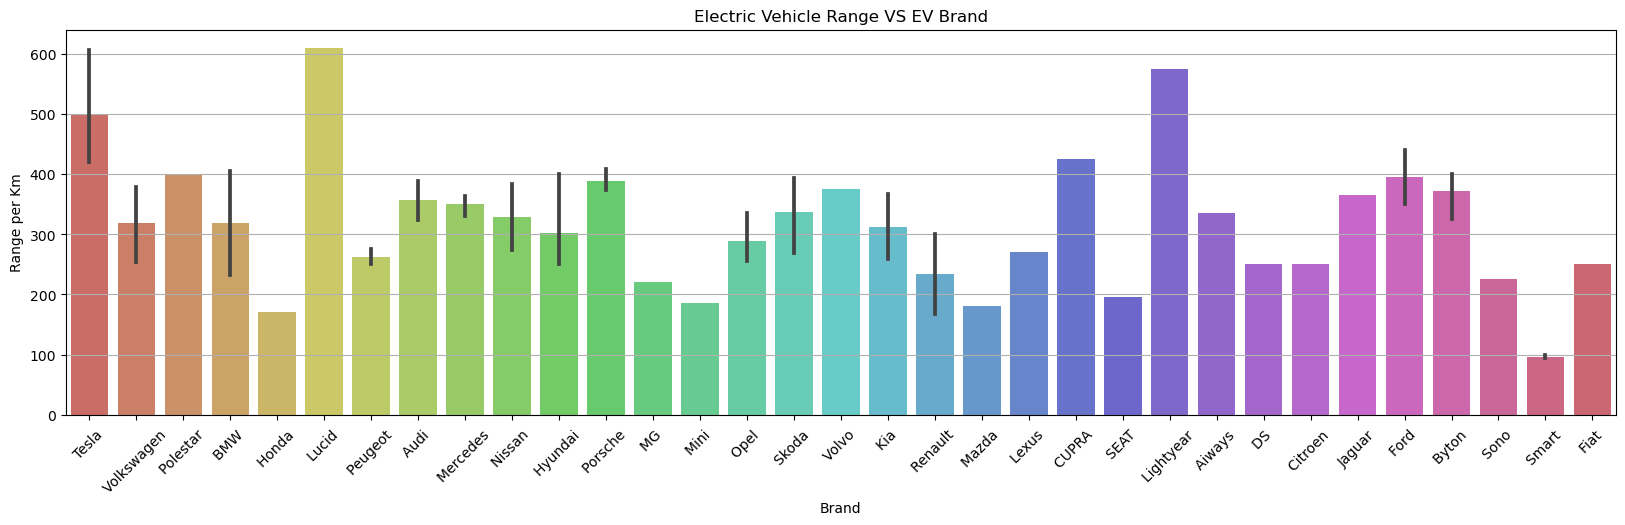

In [12]:
#Analysis range by EV Brand
ax= plt.figure(figsize=(20,5))
sns.barplot(x='Brand',y='Range_Km',data=ev,palette='hls')
plt.grid(axis='y')
plt.title('Electric Vehicle Range VS EV Brand')
plt.xlabel('Brand')
plt.ylabel('Range per Km')
plt.xticks(rotation=45)

The electric vehicles with the greatest range are Lightyear, Lucid, and Tesla, with Smart having the least.

# Model with highest Range

In [13]:
range_df = ev.sort_values(by=['Range_Km'], ascending=False)
range_df[['Brand','Model','Range_Km']].head(n=1)

,Brand,Model,Range_Km
51,Tesla,Roadster,970


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 [Text(0, 0, 'Tesla '),
  Text(1, 0, 'Volkswagen '),
  Text(2, 0, 'Polestar '),
  Text(3, 0, 'BMW '),
  Text(4, 0, 'Honda '),
  Text(5, 0, 'Lucid '),
  Text(6, 0, 'Peugeot '),
  Text(7, 0, 'Audi '),
  Text(8, 0, 'Mercedes '),
  Text(9, 0, 'Nissan '),
  Text(10, 0, 'Hyundai '),
  Text(11, 0, 'Porsche '),
  Text(12, 0, 'MG '),
  Text(13, 0, 'Mini '),
  Text(14, 0, 'Opel '),
  Text(15, 0, 'Skoda '),
  Text(16, 0, 'Volvo '),
  Text(17, 0, 'Kia '),
  Text(18, 0, 'Renault '),
  Text(19, 0, 'Mazda '),
  Text(20, 0, 'Lexus '),
  Text(21, 0, 'CUPRA '),
  Text(22, 0, 'SEAT '),
  Text(23, 0, 'Lightyear '),
  Text(24, 0, 'Aiways '),
  Text(25, 0, 'DS '),
  Text(26, 0, 'Citroen '),
  Text(27, 0, 'Jaguar '),
  Text(28, 0, 'Ford '),
  Text(29, 0, 'Byton '),
  Text(30, 0, 'Sono '),
  Text(31, 0, 'Smart '),
  Text(32, 0, 'Fiat ')])

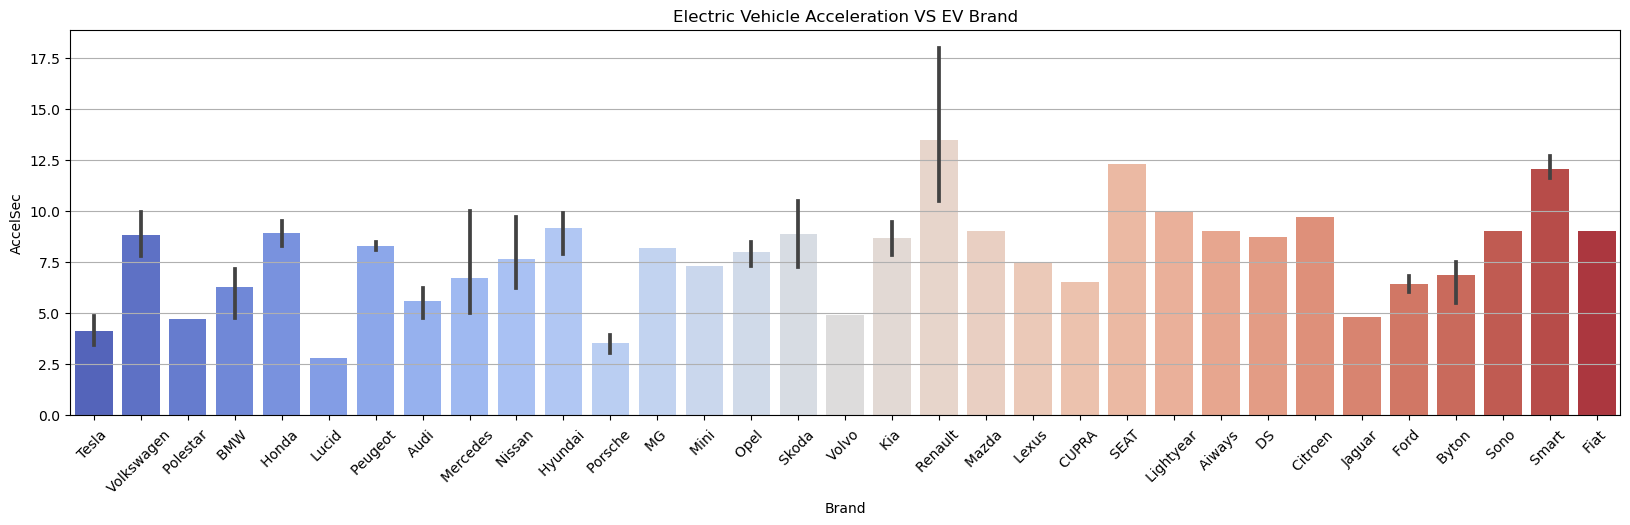

In [14]:
#Analysis acceleration by EV Brand
ax= plt.figure(figsize=(20,5))
sns.barplot(x='Brand',y='AccelSec',data=ev,palette='coolwarm')
plt.grid(axis='y')
plt.title('Electric Vehicle Acceleration VS EV Brand')
plt.xlabel('Brand')
plt.ylabel('AccelSec')
plt.xticks(rotation=45)

The top three vehicles for quick acceleration to 60 mph (97 km/h) are Lucid, Tesla, and Porsche. In contrast, Renault has the slowest acceleration.

# Model with the shortest Acceleration time

In [15]:
df = ev.sort_values(by=['AccelSec'], ascending=True)
df[['Brand','Model','AccelSec']].head(n=1)

,Brand,Model,AccelSec
51,Tesla,Roadster,2.1


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 [Text(0, 0, 'Tesla '),
  Text(1, 0, 'Volkswagen '),
  Text(2, 0, 'Polestar '),
  Text(3, 0, 'BMW '),
  Text(4, 0, 'Honda '),
  Text(5, 0, 'Lucid '),
  Text(6, 0, 'Peugeot '),
  Text(7, 0, 'Audi '),
  Text(8, 0, 'Mercedes '),
  Text(9, 0, 'Nissan '),
  Text(10, 0, 'Hyundai '),
  Text(11, 0, 'Porsche '),
  Text(12, 0, 'MG '),
  Text(13, 0, 'Mini '),
  Text(14, 0, 'Opel '),
  Text(15, 0, 'Skoda '),
  Text(16, 0, 'Volvo '),
  Text(17, 0, 'Kia '),
  Text(18, 0, 'Renault '),
  Text(19, 0, 'Mazda '),
  Text(20, 0, 'Lexus '),
  Text(21, 0, 'CUPRA '),
  Text(22, 0, 'SEAT '),
  Text(23, 0, 'Lightyear '),
  Text(24, 0, 'Aiways '),
  Text(25, 0, 'DS '),
  Text(26, 0, 'Citroen '),
  Text(27, 0, 'Jaguar '),
  Text(28, 0, 'Ford '),
  Text(29, 0, 'Byton '),
  Text(30, 0, 'Sono '),
  Text(31, 0, 'Smart '),
  Text(32, 0, 'Fiat ')])

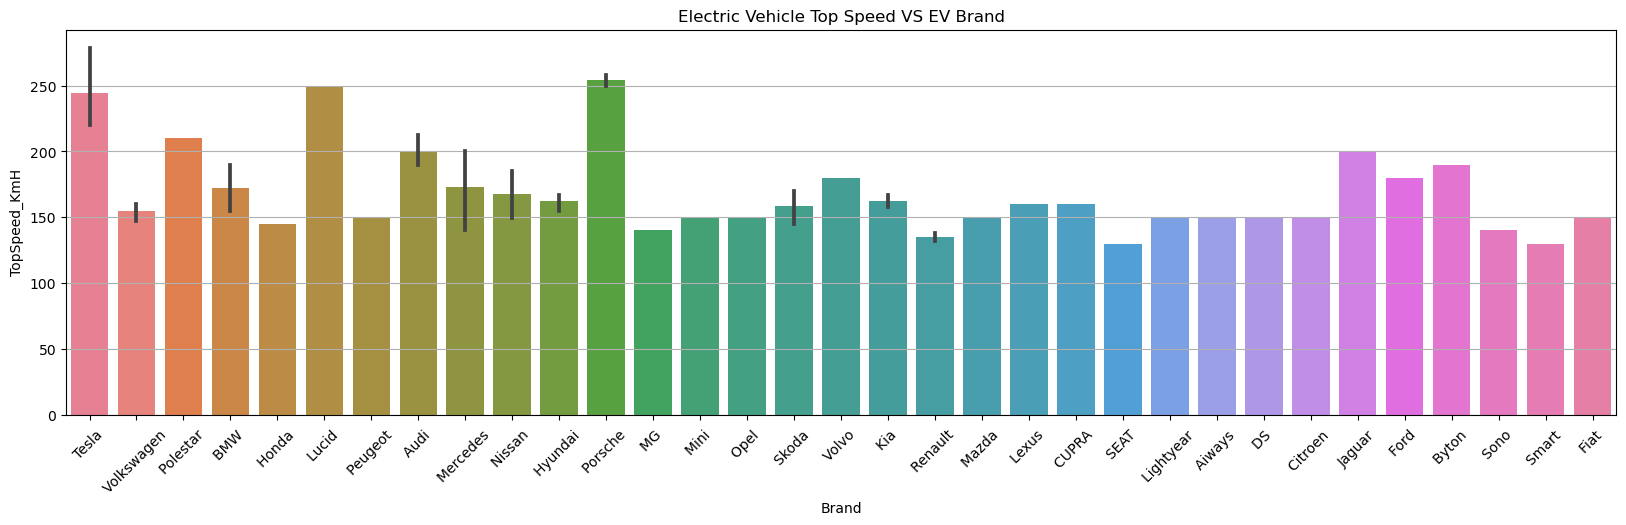

In [16]:
#Analysis top speed by EV Brand
ax= plt.figure(figsize=(20,5))
sns.barplot(x='Brand',y='TopSpeed_KmH',data=ev,palette='husl')
plt.grid(axis='y')
plt.title('Electric Vehicle Top Speed VS EV Brand')
plt.xlabel('Brand')
plt.ylabel('TopSpeed_KmH')
plt.xticks(rotation=45)

Among the vehicles, Tesla, Porsche, and Lucid boast the highest top speeds, whereas Seat ranks the lowest.

# Model with Top Speed

In [17]:
speed_df = ev.sort_values(by=['TopSpeed_KmH'], ascending=False)
speed_df[['Brand','Model','TopSpeed_KmH']].head(n=1)

,Brand,Model,TopSpeed_KmH
51,Tesla,Roadster,410


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 [Text(0, 0, 'Tesla '),
  Text(1, 0, 'Volkswagen '),
  Text(2, 0, 'Polestar '),
  Text(3, 0, 'BMW '),
  Text(4, 0, 'Honda '),
  Text(5, 0, 'Lucid '),
  Text(6, 0, 'Peugeot '),
  Text(7, 0, 'Audi '),
  Text(8, 0, 'Mercedes '),
  Text(9, 0, 'Nissan '),
  Text(10, 0, 'Hyundai '),
  Text(11, 0, 'Porsche '),
  Text(12, 0, 'MG '),
  Text(13, 0, 'Mini '),
  Text(14, 0, 'Opel '),
  Text(15, 0, 'Skoda '),
  Text(16, 0, 'Volvo '),
  Text(17, 0, 'Kia '),
  Text(18, 0, 'Renault '),
  Text(19, 0, 'Mazda '),
  Text(20, 0, 'Lexus '),
  Text(21, 0, 'CUPRA '),
  Text(22, 0, 'SEAT '),
  Text(23, 0, 'Lightyear '),
  Text(24, 0, 'Aiways '),
  Text(25, 0, 'DS '),
  Text(26, 0, 'Citroen '),
  Text(27, 0, 'Jaguar '),
  Text(28, 0, 'Ford '),
  Text(29, 0, 'Byton '),
  Text(30, 0, 'Sono '),
  Text(31, 0, 'Smart '),
  Text(32, 0, 'Fiat ')])

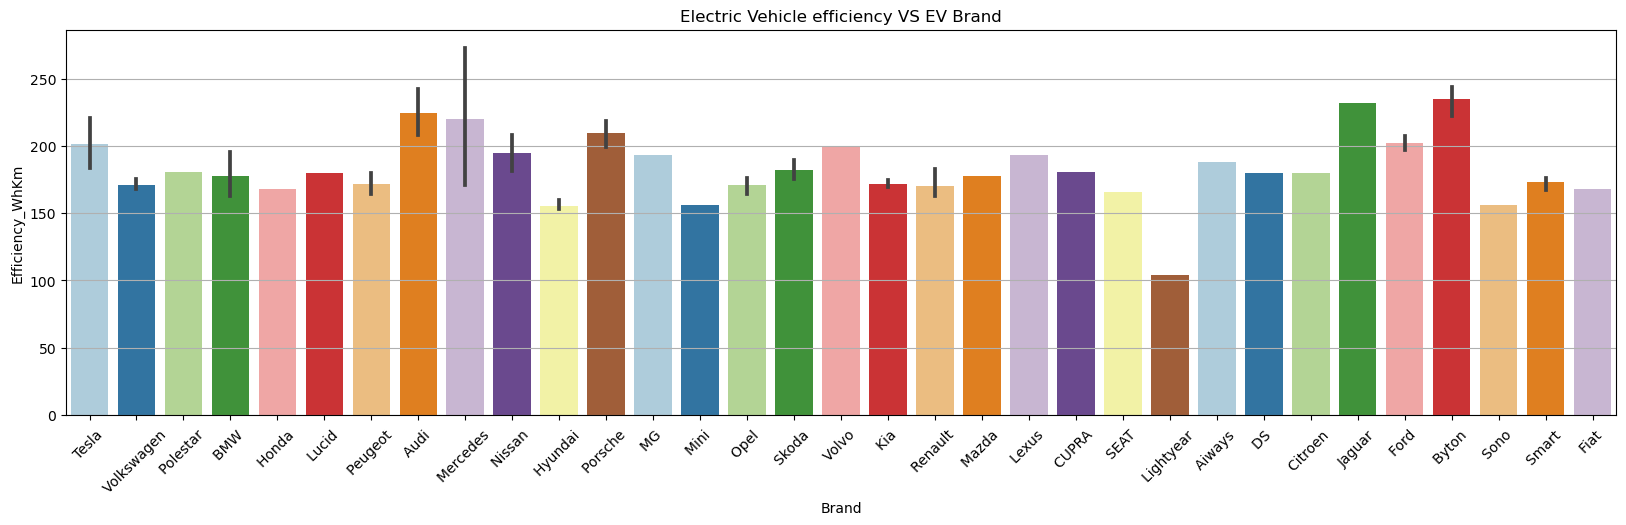

In [18]:
#Analysis efficiency by EV Brand
ax= plt.figure(figsize=(20,5))
sns.barplot(x='Brand',y='Efficiency_WhKm',data=ev,palette='Paired')
plt.grid(axis='y')
plt.title('Electric Vehicle efficiency VS EV Brand')
plt.xlabel('Brand')
plt.ylabel('Efficiency_WhKm')
plt.xticks(rotation=45)

Among the vehicles, Mercedes, Audi, and Byton are the most efficient, with Lightyear being the least efficient.

# Model with maximum Efficiency

In [19]:
eff_df = ev.sort_values(by=['Efficiency_WhKm'], ascending=False)
eff_df[['Brand','Model','Efficiency_WhKm']].head(n=1)

,Brand,Model,Efficiency_WhKm
84,Mercedes,EQV 300 Long,273


# Model with the highest Range & maximum seats 

In [20]:
seat_df = ev.sort_values(by=['Seats'], ascending=False)
seat_df[['Brand','Model','Range_Km', 'Seats']].head(n=1)

,Brand,Model,Range_Km,Seats
21,Tesla,Model Y Long Range Dual Motor,425,7


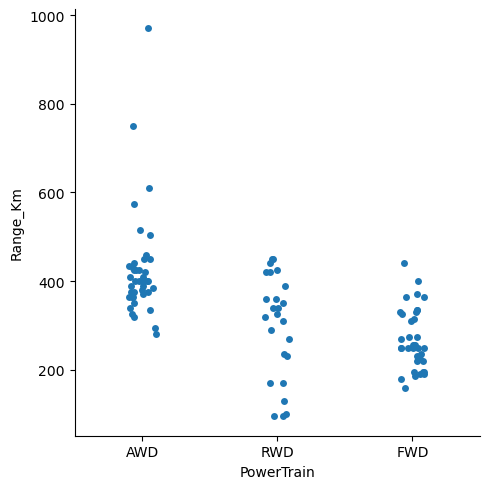

In [21]:
##Distribution of range with PowerTrain
fig, axs = plt.subplots(1,2)
sns.catplot(x="PowerTrain", y="Range_Km", data=ev)
plt.close(1)

# 3. Encoding categorical data

In [22]:
ev.columns

Index(['Brand', 'Model', 'AccelSec', 'TopSpeed_KmH', 'Range_Km',
       'Efficiency_WhKm', 'FastCharge_KmH', 'RapidCharge', 'PowerTrain',
       'PlugType', 'BodyStyle', 'Segment', 'Seats', 'PriceEuro'],
      dtype='object')

In [23]:
ev1 = ev[['Brand', 'Model', 'PowerTrain', 'RapidCharge', 'PlugType', 'BodyStyle', 'Segment']]

In [24]:
print(ev1)

# define ordinal encoding
encoder = OrdinalEncoder()

# transform data
result = encoder.fit_transform(ev1)
print(result)

           Brand                            Model PowerTrain RapidCharge  \
0         Tesla     Model 3 Long Range Dual Motor        AWD         Yes   
1    Volkswagen                         ID.3 Pure        RWD         Yes   
2      Polestar                                 2        AWD         Yes   
3           BMW                              iX3         RWD         Yes   
4         Honda                                e         RWD         Yes   
..           ...                              ...        ...         ...   
98       Nissan                       Ariya 63kWh        FWD         Yes   
99         Audi     e-tron S Sportback 55 quattro        AWD         Yes   
100      Nissan               Ariya e-4ORCE 63kWh        AWD         Yes   
101      Nissan   Ariya e-4ORCE 87kWh Performance        AWD         Yes   
102       Byton                 M-Byte 95 kWh 2WD        AWD         Yes   

       PlugType  BodyStyle Segment  
0    Type 2 CCS      Sedan       D  
1    Type 2 C

In [25]:
temp = ['Brand', 'Model', 'PowerTrain', 'RapidCharge', 'PlugType', 'BodyStyle', 'Segment']

In [26]:
ev.drop(temp,axis=1,inplace=True)

In [27]:
result = pd.DataFrame(result)

In [28]:
result.columns=["Brand", "Model", "PowerTrain", 'RapidCharge', "PlugType", "BodyStyle", "Segment"]
result.index+=1

In [29]:
result

,Brand,Model,PowerTrain,RapidCharge,PlugType,BodyStyle,Segment
1,30.0,46.0,0.0,1.0,2.0,7.0,3.0
2,31.0,33.0,2.0,1.0,2.0,1.0,2.0
3,23.0,0.0,0.0,1.0,2.0,2.0,3.0
4,2.0,101.0,2.0,1.0,2.0,6.0,3.0
5,9.0,78.0,2.0,1.0,2.0,1.0,1.0
...,...,...,...,...,...,...,...
99,20.0,6.0,1.0,1.0,2.0,1.0,2.0
100,1.0,94.0,0.0,1.0,2.0,6.0,4.0
101,20.0,8.0,0.0,1.0,2.0,1.0,2.0
102,20.0,10.0,0.0,1.0,2.0,1.0,2.0


In [30]:
ev1 = ev
ev1.index+=1

In [31]:
ev1[['Brand', 'Model', 'PowerTrain', 'RapidCharge', 'PlugType', 'BodyStyle', 'Segment']] = result[['Brand', 'Model', 'PowerTrain', 'RapidCharge', 'PlugType', 'BodyStyle', 'Segment']]
ev

,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,Seats,PriceEuro,Brand,Model,PowerTrain,RapidCharge,PlugType,BodyStyle,Segment
1,4.6,233,450,161,940,5,55480,30.0,46.0,0.0,1.0,2.0,7.0,3.0
2,10.0,160,270,167,250,5,30000,31.0,33.0,2.0,1.0,2.0,1.0,2.0
3,4.7,210,400,181,620,5,56440,23.0,0.0,0.0,1.0,2.0,2.0,3.0
4,6.8,180,360,206,560,5,68040,2.0,101.0,2.0,1.0,2.0,6.0,3.0
5,9.5,145,170,168,190,4,32997,9.0,78.0,2.0,1.0,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,7.5,160,330,191,440,5,45000,20.0,6.0,1.0,1.0,2.0,1.0,2.0
100,4.5,210,335,258,540,5,96050,1.0,94.0,0.0,1.0,2.0,6.0,4.0
101,5.9,200,325,194,440,5,50000,20.0,8.0,0.0,1.0,2.0,1.0,2.0
102,5.1,200,375,232,450,5,65000,20.0,10.0,0.0,1.0,2.0,1.0,2.0


In [32]:
#Check correlation between different features
ev.corr()

/tmp/wsuser/ipykernel_163/1758374523.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ev.corr()


,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,Seats,PriceEuro,Brand,Model,PowerTrain,RapidCharge,PlugType,BodyStyle,Segment
AccelSec,1.000000,-0.786195,-0.677062,-0.382904,-0.175335,-0.627174,0.062730,-0.050635,0.521011,-0.514820,-0.259657,-0.347164,-0.451568
TopSpeed_KmH,-0.786195,1.000000,0.746662,0.355675,0.126470,0.829057,0.101759,0.067814,-0.560538,0.251054,-0.010110,0.339230,0.670403
Range_Km,-0.677062,0.746662,1.000000,0.313077,0.300163,0.674844,0.088316,-0.066035,-0.451495,0.401290,0.131297,0.227477,0.628597
Efficiency_WhKm,-0.382904,0.355675,0.313077,1.000000,0.301230,0.396705,-0.195901,0.010976,-0.394721,0.105673,-0.028761,0.373146,0.623263
Seats,-0.175335,0.126470,0.300163,0.301230,1.000000,0.020920,0.089589,-0.018943,-0.278882,0.423111,-0.029570,0.342489,0.416744
PriceEuro,-0.627174,0.829057,0.674844,0.396705,0.020920,1.000000,-0.036023,0.169003,-0.561584,0.197208,-0.000193,0.321713,0.737106
Brand,0.062730,0.101759,0.088316,-0.195901,0.089589,-0.036023,1.000000,-0.401572,0.056464,-0.188137,-0.231104,-0.275860,-0.002040
Model,-0.050635,0.067814,-0.066035,0.010976,-0.018943,0.169003,-0.401572,1.000000,-0.007609,0.144293,0.023750,0.261255,0.068414
PowerTrain,0.521011,-0.560538,-0.451495,-0.394721,-0.278882,-0.561584,0.056464,-0.007609,1.000000,-0.274797,-0.039763,-0.349484,-0.497850
RapidCharge,-0.514820,0.251054,0.401290,0.105673,0.423111,0.197208,-0.188137,0.144293,-0.274797,1.000000,0.539160,0.223577,0.189954


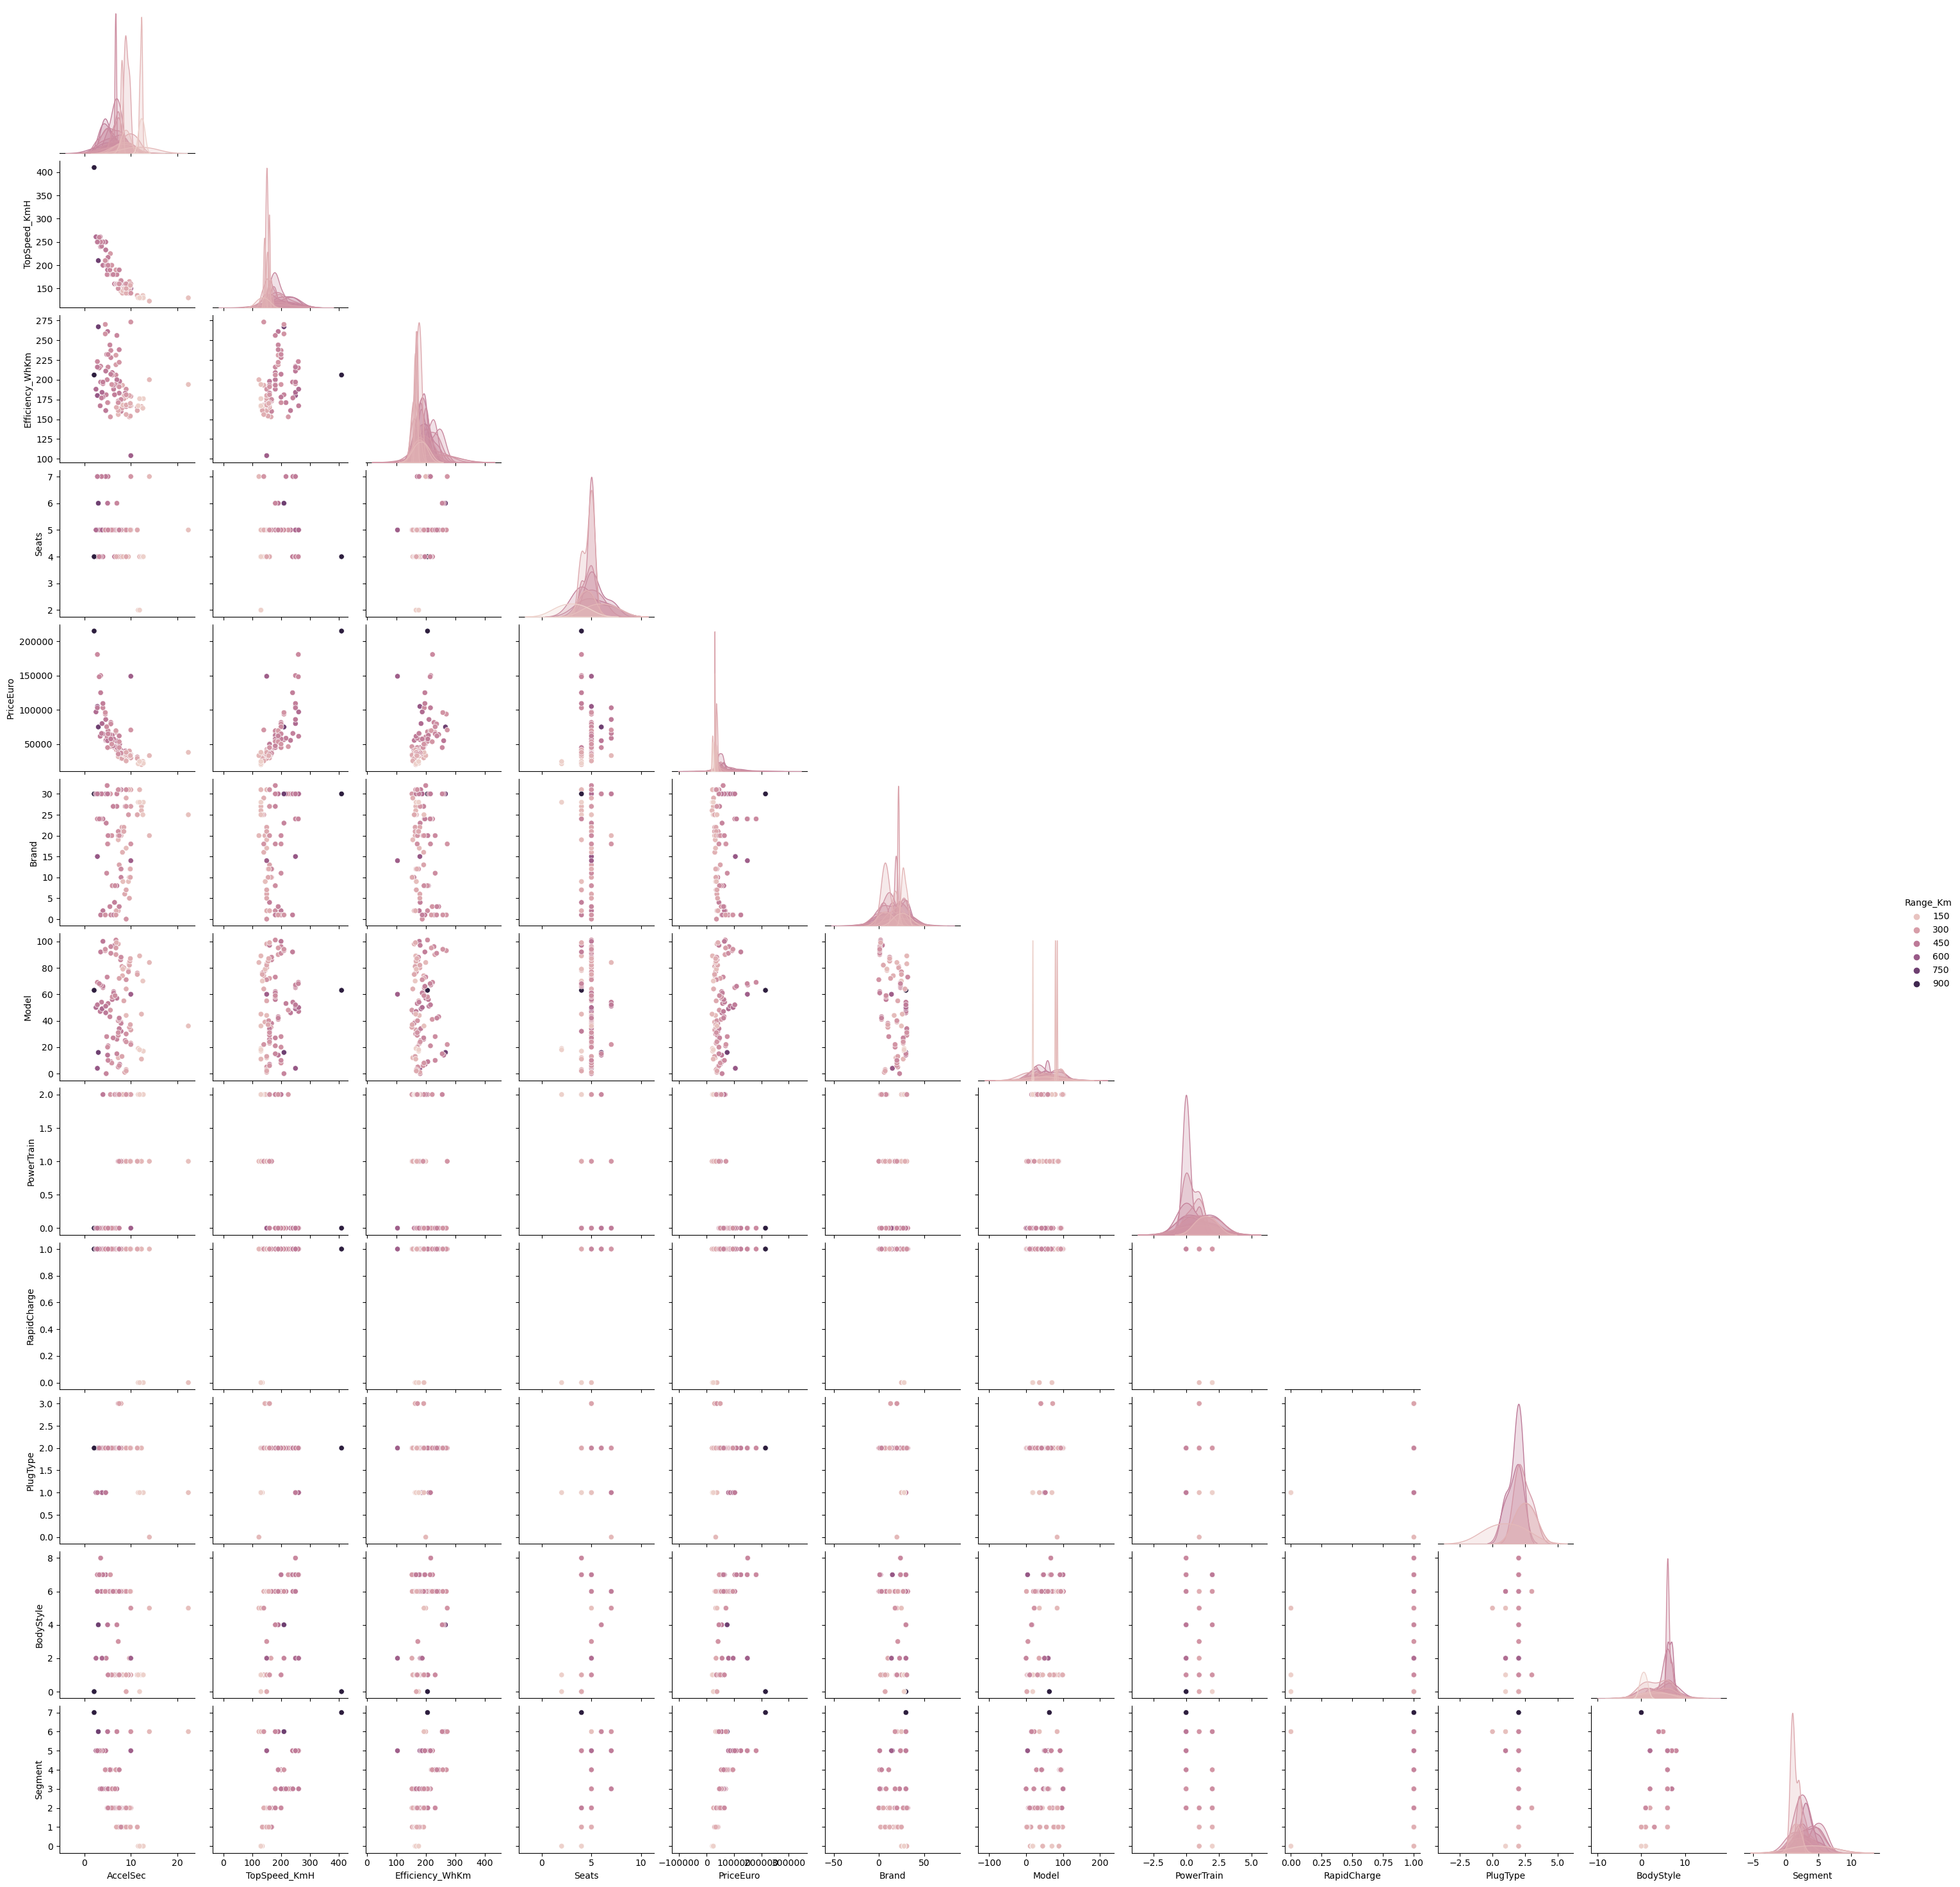

In [33]:
#Pairplot show the correlation of the data
sns.pairplot(ev,
             corner = True,
             kind = 'scatter',
             hue = 'Range_Km')
plt.show()

/tmp/wsuser/ipykernel_163/3497584810.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(ev.corr(),linewidths=1,linecolor='white',annot=True)


<Axes: >

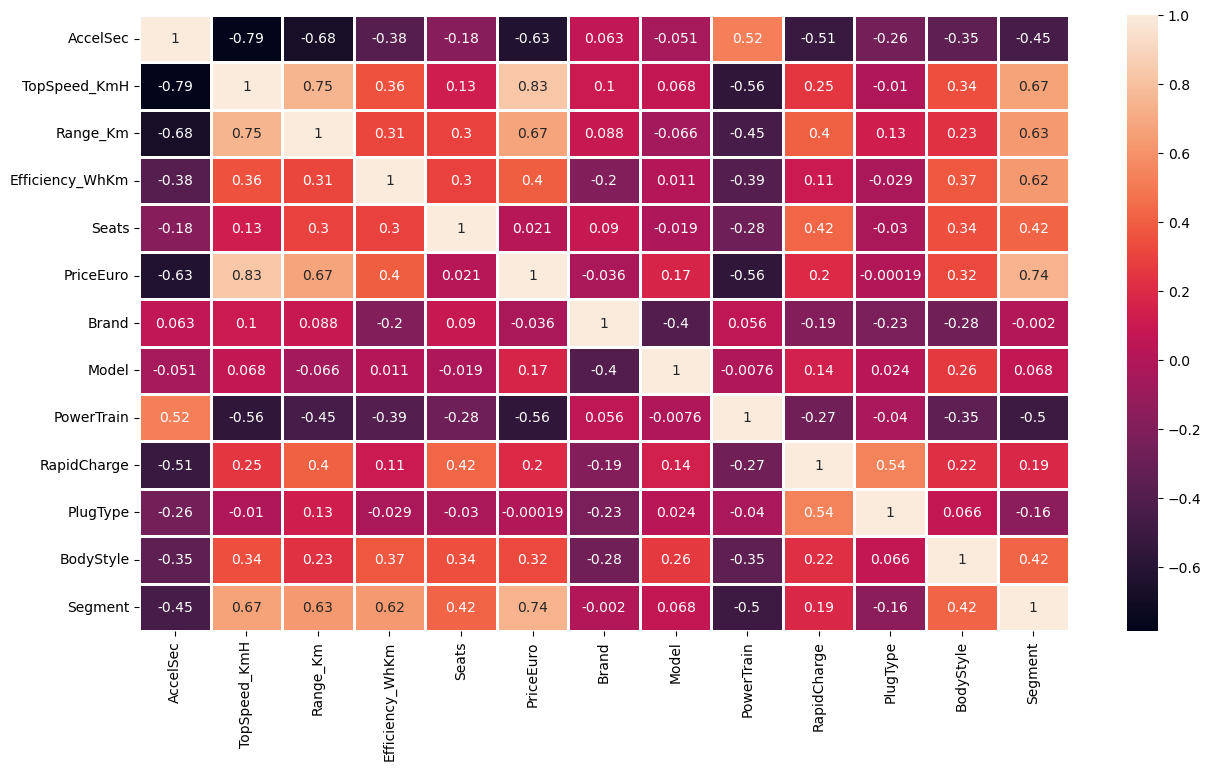

In [34]:
#Heatmap to show the correlation of the data
ax= plt.figure(figsize=(15,8))
sns.heatmap(ev.corr(),linewidths=1,linecolor='white',annot=True)

The range of electric vehicles shows a strong positive correlation with top speed per kilometer driven. This suggests that predicting the range could be a good indicator of top speed per kilometer.

# 4. Feature Selection

In [35]:
#Define the target value(dependant variable) as y
X = ev['TopSpeed_KmH'].values.reshape(-1,1)
y = ev['Range_Km']

# 5. Using Linear Regression Create a Model 

# Linear Regression Model Overview

## Strengths:

- Simple Implementation: Linear Regression is straightforward to implement and often yields satisfactory results with minimal complexity.

- Performance on Linearly Separable Datasets: It effectively fits linearly separable datasets, making it a useful tool for understanding the nature of relationships between variables.

- Reduced Overfitting with Regularization: Regularization techniques can mitigate overfitting, a situation where the model fits the training data too closely, including noise and anomalies.

## Weaknesses:

- Prone to Underfitting: Underfitting occurs when the model fails to capture the underlying trends in the data, often due to an overly simplistic hypothesis function.

- Sensitive to Outliers: Linear Regression can be heavily influenced by outliers or extreme values, which can skew results and affect the model's performance.

- Assumes Independence of Data: The model assumes that input variables are independent. Multicollinearity among predictors can undermine the effectiveness of Linear Regression, necessitating its removal before application.

## Assumptions:

- Linear Relationship: There is a linear relationship between the independent variable (x) and the dependent variable (y).

- Independence of Residuals: Residuals should be independent of each other, with no correlation between consecutive residuals, particularly in time series data.

- Homoscedasticity: Residuals should have constant variance at every level of x.

- Normality of Residuals: The residuals should be normally distributed for accurate inference and prediction.

In [36]:
#Training and Test Data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [37]:
## Check Shape, Sample of Test Train Data
print("X_train : ",X_train.shape)

print("X_test : ",X_test.shape)

print("y_train : ",y_train.shape)

print("y_test : ",y_test.shape)


X_train :  (82, 1)
X_test :  (21, 1)
y_train :  (82,)
y_test :  (21,)


In [38]:
# Create Linear Model
lr = LinearRegression()

#Model Fitting
lr.fit(X_train, y_train)

LinearRegression()

In [39]:
#We can output a prediction
y_pred = lr.predict(X_test)
y_pred[0:5]

array([359.60303889, 359.60303889, 292.8263226 , 493.15647147,
       381.86194432])

Let us assume we have the following details:

Electric Vehicle Details:
    Acceleration (0-60 mph) Time: 5.8 seconds
    Top Speed: 248 km/h
    Efficiency: 200 Wh/km
    Fast Charging Rate: 400 km/h
    Powertrain: All-Wheel Drive (AWD)
    Plug Type: Type 2 CCS
    Body Style: Hatchback
    Range: ? km
    Seats: 5

In [40]:
#Predict the range of this EV using linear regression model.

# TopSpeed_Kmh = 248

EV_pred = lr.predict([[248]])
print(EV_pred)

[488.70469038]


We can predict the Range of this sample EV is 488 km. 

In [41]:
# Check Coefficient
lr.coef_

array([2.22589054])

In [42]:
#Check intercept
lr.intercept_

-63.3161642577993

Let's visualize Range as potential predictor variable of Top Speed

(0.0, 1013.75)

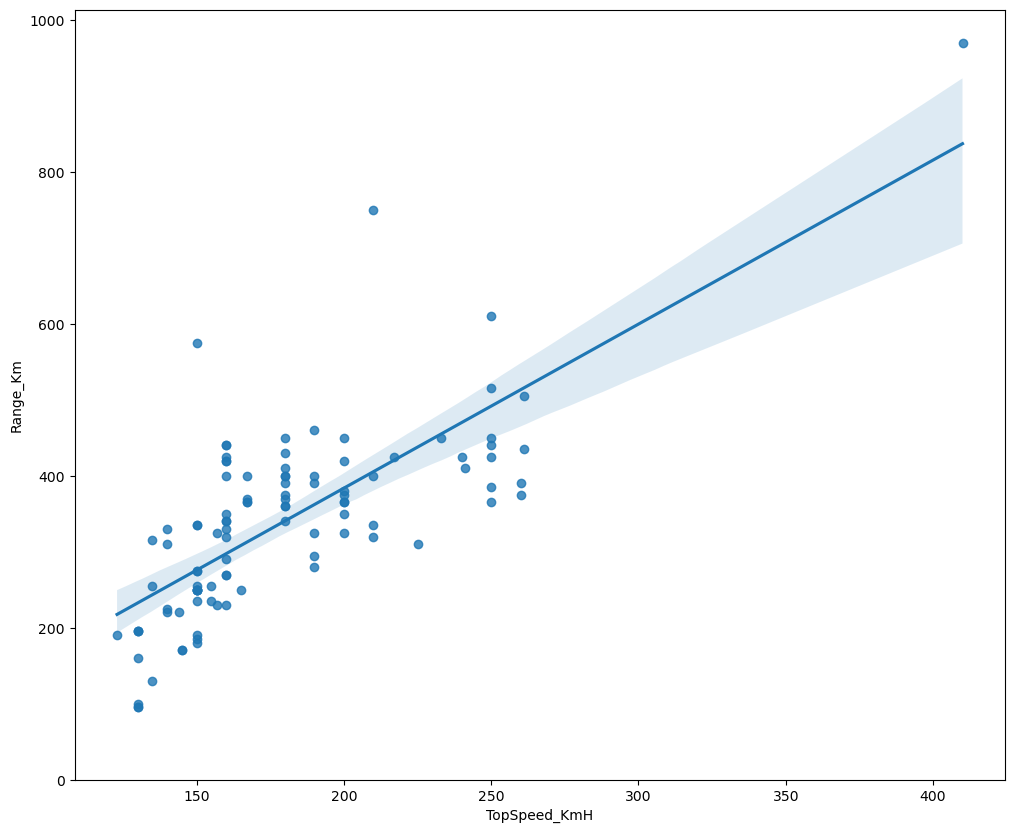

In [43]:
width = 12
height = 10
plt.figure(figsize=(width, height))
sns.regplot(x="TopSpeed_KmH", y="Range_Km", data=ev)
plt.ylim(0,)

From this plot, we observe a positive correlation between range and top speed per km/h, indicated by the positive slope of the regression line. A positive slope means that as the top speed increases, the range also increases, with the function rising "uphill." This implies that higher top speeds are associated with longer ranges.

The fitted values in a linear regression model represent the predicted values of the outcome variable based on the model's parameters. To evaluate the model’s performance, we should compare the distribution of these fitted values to the distribution of the actual values.

Let’s examine the distribution of the fitted values generated by the model and compare it with the distribution of the actual values to assess how well the model predicts the outcome.

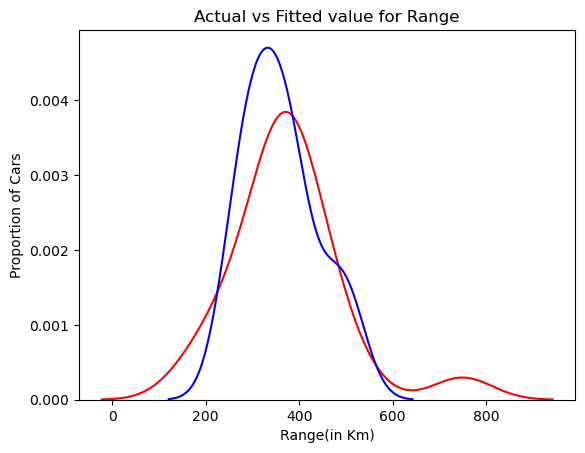

In [44]:
ax1 = sns.kdeplot(y_test, color="r", label="Actual Value")
sns.kdeplot(y_pred, color="b", label="Fitted Values", ax=ax1)
plt.title('Actual vs Fitted value for Range')
plt.xlabel('Range(in Km)')
plt.ylabel('Proportion of Cars')
plt.show()
plt.close()


The fitted values are reasonably close to the actual values, as evidenced by the overlap between their distributions. However, there is still room for improvement in the model's predictions.

# 6. Model Evaluation (Regression Metrics)

In [45]:
# Calculate the score for Training Data
lr.score(X_train, y_train)
print("R2 for Traing Data: ", lr.score(X_train, y_train))

R2 for Traing Data:  0.6297694922844455


In [46]:
# Calculate the score (R^2 for Regression) for Testing Data
lr.score(X_test, y_test)
print("R2 for Testing Data: ", lr.score(X_test, y_test))

R2 for Testing Data:  0.15363068038695216


In [47]:
#Calculate Mean Squared Error
mean_squared_error(y_test, y_pred)
print("MSE: ", mean_squared_error(y_test, y_pred))

MSE:  11242.893676247608


In [48]:
#Calculate Mean Absolute Error(MAE)
mean_absolute_error(y_test, y_pred)
print("MAE: ",mean_absolute_error(y_test, y_pred))

MAE:  78.18137850937941


In [49]:
#Calculate Root Mean Squared Error(RMSE)

print("RMSE: ",np.sqrt(mean_squared_error(y_test,y_pred)))

RMSE:  106.03251235469057


# 7. Use Forward Feature Selection to pick a good model

In [50]:
# Predictors
X = ev[['TopSpeed_KmH','Efficiency_WhKm','Segment','Seats','AccelSec','PriceEuro']]

In [51]:
# Target
y = ev['Range_Km']

In [52]:
## Create training and testing subsets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

reate a regression model using Forward Feature Selection by iteratively adding features one by one. Continue adding features until no further improvements are observed in the prediction metrics, such as R² and Adjusted R².

In [53]:
## Flag intermediate output

show_steps = True   # for testing/debugging
# show_steps = False  # without showing steps

# Use Forward Feature Selection to pick a good model

# start with no predictors
included = []
# keep track of model and parameters
best = {'feature': '', 'r2': 0, 'a_r2': 0}
# create a model object to hold the modelling parameters
model = LinearRegression()
# get the number of cases in the training data
n = X_train.shape[0]

r2_list = []
adjusted_r2_list = []

while True:
    changed = False
    
    if show_steps:
        print('') 

    # list the features to be evaluated
    excluded = list(set(X.columns) - set(included))
    
    if show_steps:
        print('(Step) Excluded = %s' % ', '.join(excluded))  

    # for each remaining feature to be evaluated
    for new_column in excluded:
        
        if show_steps:
            print('(Step) Trying %s...' % new_column)
            print('(Step) - Features = %s' % ', '.join(included + [new_column]))

        # fit the model with the Training data
        fit = model.fit(X_train[included + [new_column]], y_train)
        # calculate the score (R^2 for Regression)
        r2 = fit.score(X_train[included + [new_column]], y_train)
        
        # number of predictors in this model
        k = len(included) + 1
        # calculate the adjusted R^2
        adjusted_r2 = 1 - ( ( (1 - r2) * (n - 1) ) / (n - k - 1) )
        
        if show_steps:
            print('(Step) - Adjusted R^2: This = %.3f; Best = %.3f' % 
                  (adjusted_r2, best['a_r2']))

        # if model improves
        if adjusted_r2 > best['a_r2']:
            # record new parameters
            best = {'feature': new_column, 'r2': r2, 'a_r2': adjusted_r2}
            # flag that found a better model
            changed = True
            if show_steps:
                print('(Step) - New Best!   : Feature = %s; R^2 = %.3f; Adjusted R^2 = %.3f' % 
                      (best['feature'], best['r2'], best['a_r2']))
    # END for
    
    r2_list.append(best['r2'])
    adjusted_r2_list.append(best['a_r2'])

    # if found a better model after testing all remaining features
    if changed:
        # update control details
        included.append(best['feature'])
        excluded = list(set(excluded) - set(best['feature']))
        print('Added feature %-4s with R^2 = %.3f and adjusted R^2 = %.3f' % 
              (best['feature'], best['r2'], best['a_r2']))
    else:
        # terminate if no better model
        print('*'*50)
        break

print('')
print('Resulting features:')
print(', '.join(included))


(Step) Excluded = Segment, TopSpeed_KmH, Seats, Efficiency_WhKm, PriceEuro, AccelSec
(Step) Trying Segment...
(Step) - Features = Segment
(Step) - Adjusted R^2: This = 0.382; Best = 0.000
(Step) - New Best!   : Feature = Segment; R^2 = 0.390; Adjusted R^2 = 0.382
(Step) Trying TopSpeed_KmH...
(Step) - Features = TopSpeed_KmH
(Step) - Adjusted R^2: This = 0.625; Best = 0.382
(Step) - New Best!   : Feature = TopSpeed_KmH; R^2 = 0.630; Adjusted R^2 = 0.625
(Step) Trying Seats...
(Step) - Features = Seats
(Step) - Adjusted R^2: This = 0.055; Best = 0.625
(Step) Trying Efficiency_WhKm...
(Step) - Features = Efficiency_WhKm
(Step) - Adjusted R^2: This = 0.064; Best = 0.625
(Step) Trying PriceEuro...
(Step) - Features = PriceEuro
(Step) - Adjusted R^2: This = 0.549; Best = 0.625
(Step) Trying AccelSec...
(Step) - Features = AccelSec
(Step) - Adjusted R^2: This = 0.452; Best = 0.625
Added feature TopSpeed_KmH with R^2 = 0.630 and adjusted R^2 = 0.625

(Step) Excluded = Seats, PriceEuro, Accel

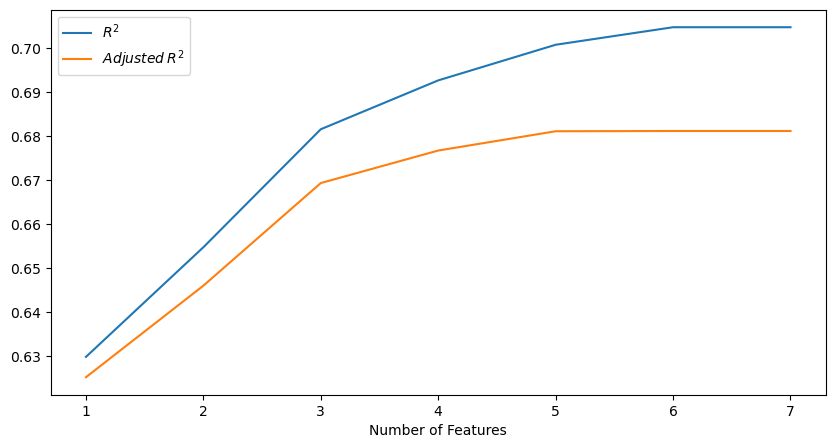

In [54]:
## Display both R^2 and Adjusted R^2

_range = range(1, len(r2_list)+1)

# define chart size
plt.figure(figsize = (10, 5))
# plot each metric 
plt.plot(_range, r2_list, label = '$R^2$')
plt.plot(_range, adjusted_r2_list, label = '$Adjusted \: R^2$')
# add some better visualisation
plt.xlabel('Number of Features')
plt.legend()
# output the chart
plt.show()

I can enhance the R² value by selecting different features. Adding an independent variable to the model will always increase the R² value.

# 8. Regularisation

Linear regression determines the coefficients for each independent variable by minimizing a loss function. However, if the coefficients become too large, it can lead to overfitting, where the model performs well on the training data but poorly on new, unseen data.

The two most common types of regularization are the Ridge and Lasso.

In [55]:
#Create a Base Model Using Linear Regression
model = LinearRegression()
# Fit
model.fit(X,y)

LinearRegression()

In [56]:
# Check Coeffiricent
model.coef_

array([ 7.47717179e-01, -6.22509843e-01,  1.65787415e+01,  2.57670219e+01,
       -1.24305613e+01,  6.04144393e-04])

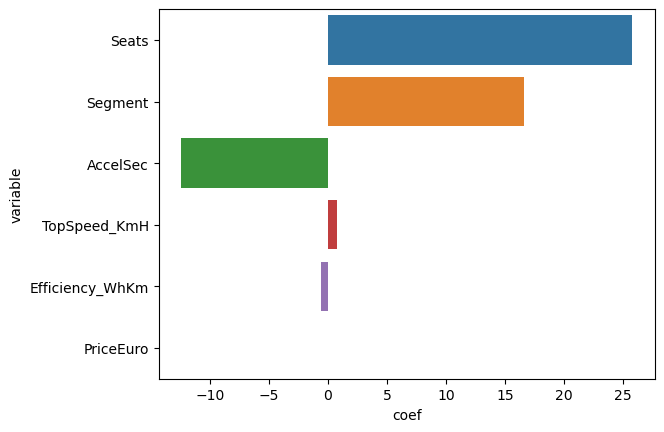

In [57]:
def view_coeff(X, model):
    model_coefs = pd.DataFrame({'variable': X.columns,
                                'coef': model.coef_,
                                'abs_coef': np.abs(model.coef_)})
    model_coefs.sort_values('abs_coef', inplace=True, ascending=False)
    sns.barplot(x="coef", y="variable", data=model_coefs)
# Plot Coefficients
view_coeff(X, model)

# 9. Calculate Ridge Regression model

In [58]:
## Calculate Ridge Regression model

# create a model object to hold the modelling parameters
ridgemodel = Ridge()

# keep track of the intermediate results for coefficients and errors
coefs = []
errors = []

# create a range of alphas to calculate
ridge_alphas = np.logspace(-6, 6, 200) #lambda in the slides

# Train the model with different regularisation strengths
for a in ridge_alphas:
    ridgemodel.set_params(alpha = a)
    ridgemodel.fit(X, y)
    coefs.append(ridgemodel.coef_)
    errors.append(mean_squared_error(ridgemodel.coef_, model.coef_))

Visual Representation of Coefficient of Ridge Model

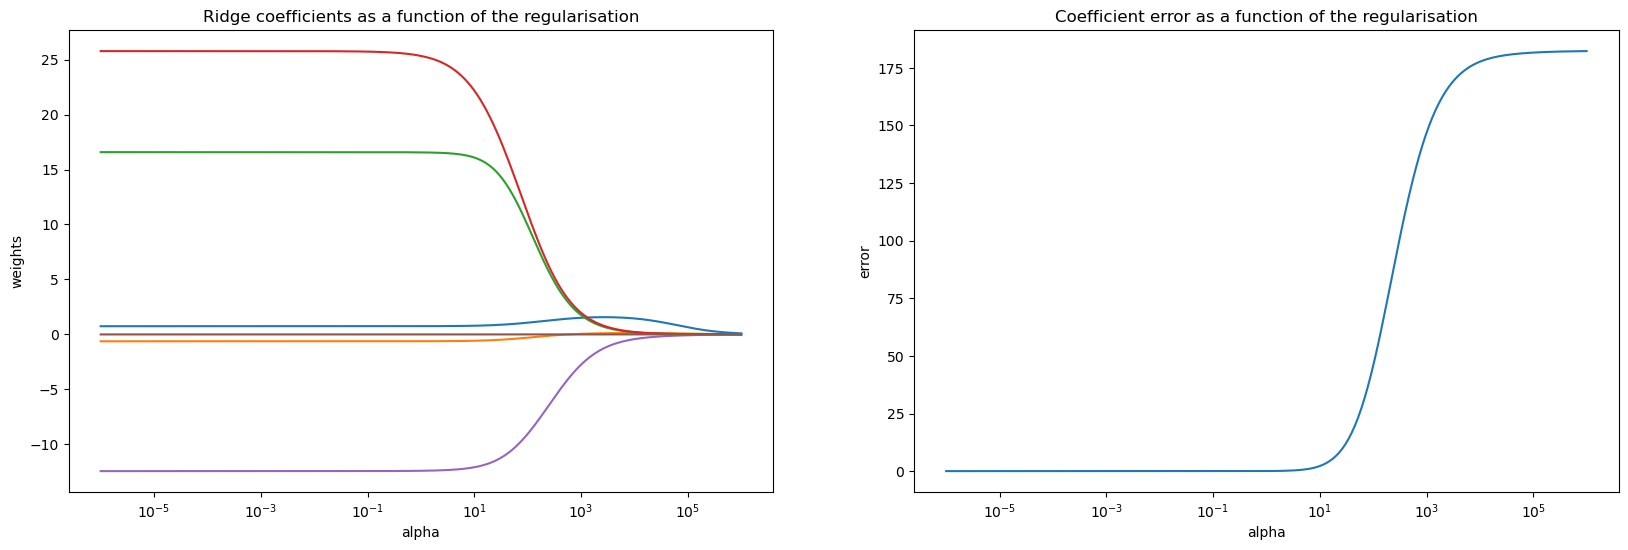

In [59]:
# Display results
plt.figure(figsize = (20, 6))

plt.subplot(121)
ax = plt.gca()
ax.plot(ridge_alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularisation')
plt.axis('tight')

plt.subplot(122)
ax = plt.gca()
ax.plot(ridge_alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.title('Coefficient error as a function of the regularisation')
plt.axis('tight')

plt.show()

Find an optimal value for Ridge regression alpha using RidgeCV

In [60]:
optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X, y)
print('Alpha:', optimal_ridge.alpha_)
print('Score:', optimal_ridge.score(X, y))

Alpha: 19.791668678535572
Score: 0.6467904685229368


In [61]:
optimal_ridge.coef_

array([ 8.33733337e-01, -5.29343039e-01,  1.53156424e+01,  1.97312130e+01,
       -1.16862263e+01,  5.71635752e-04])

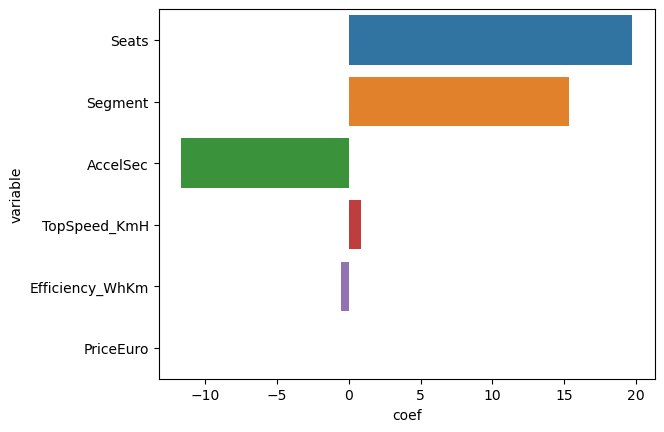

In [62]:
# Plot Coefficient
view_coeff(X, optimal_ridge)

In [63]:
rr = Ridge(alpha=0.01)
rr.fit(X_train, y_train) 
pred_train_rr= rr.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_rr)))
print(r2_score(y_train, pred_train_rr))

pred_test_rr= rr.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_rr))) 
print(r2_score(y_test, pred_test_rr))

68.50082915686325
0.7047900146524513
98.54263271897918
0.26897853326748533


The output indicates that for the Ridge Regression model, the RMSE and R-squared values on the training data are 68.5 and 70.48 percent, respectively. In contrast, for the test data, the RMSE is 98.54, and the R-squared value is 26.9 percent.

# 10. Calculate Lasso Regression model

In [64]:
## Calculate Lasso Regression model

# create a model object to hold the modelling parameters
lassomodel = Lasso()

# keep track of the intermediate results for coefficients and errors
coefs = []
errors = []

# create a range of alphas to calculate
lasso_alphas = np.logspace(-6, 6, 200) #lambda in the slides

# Train the model with different regularisation strengths
for a in lasso_alphas:
    lassomodel.set_params(alpha = a)
    lassomodel.fit(X, y)
    coefs.append(lassomodel.coef_)
    errors.append(mean_squared_error(lassomodel.coef_, model.coef_))

Visual Representation of Coefficient of Lasso Model

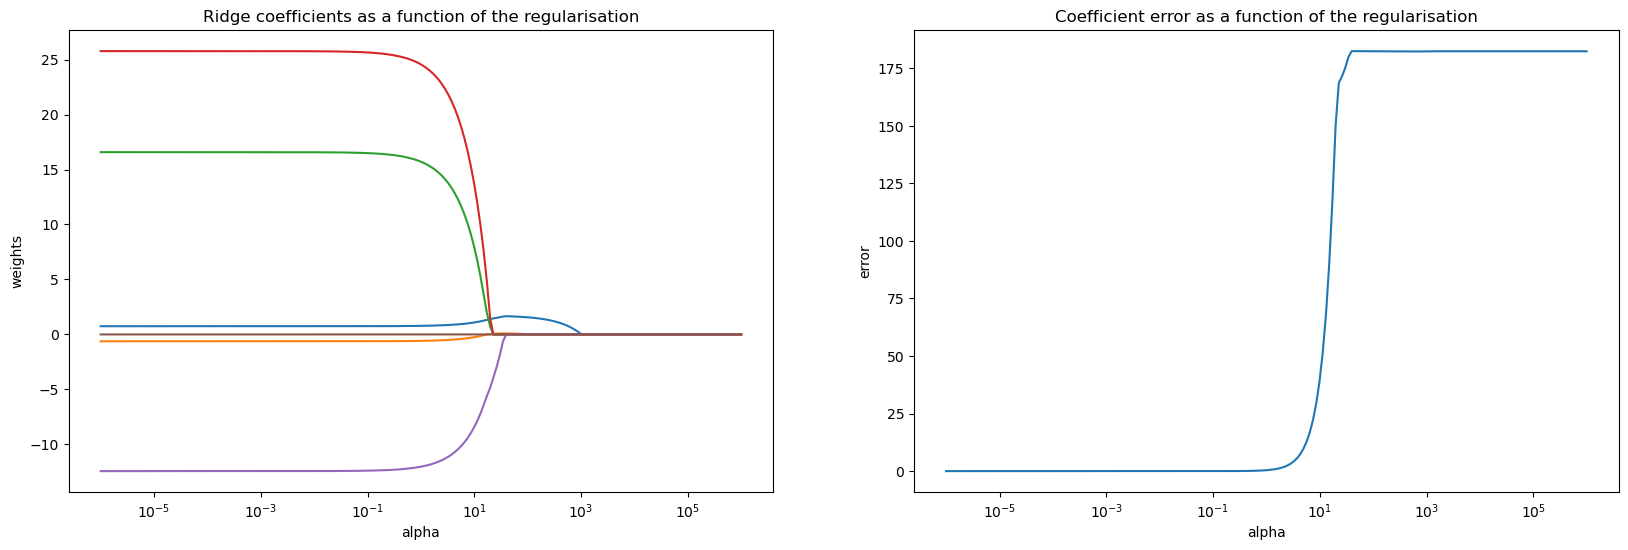

In [65]:
# Display results
plt.figure(figsize = (20, 6))

plt.subplot(121)
ax = plt.gca()
ax.plot(lasso_alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularisation')
plt.axis('tight')

plt.subplot(122)
ax = plt.gca()
ax.plot(lasso_alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.title('Coefficient error as a function of the regularisation')
plt.axis('tight')

plt.show()

Find an optimal value for Lasso regression alpha using LassoCV.

In [66]:
# Find Optimal Lasso Using LassoCV

# create a model object to hold the modelling parameters
optimal_lasso = LassoCV(alphas=lasso_alphas, cv=10)

optimal_lasso.fit(X, y)
print('Alpha:', optimal_lasso.alpha_)
print('Score:', optimal_lasso.score(X, y))

Alpha: 482.41087041653736
Score: 0.5423596191706892


In [67]:
optimal_lasso.coef_

array([ 0.91176137,  0.        ,  0.        ,  0.        , -0.        ,
        0.00152598])

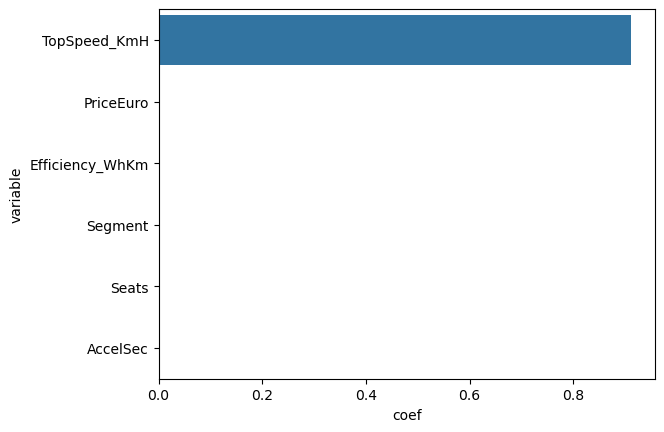

In [68]:
# Plot Coefficient
view_coeff(X, optimal_lasso)

In [69]:
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(X_train, y_train) 
pred_train_lasso= model_lasso.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
print(r2_score(y_train, pred_train_lasso))

pred_test_lasso= model_lasso.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 
print(r2_score(y_test, pred_test_lasso))

68.5008306844336
0.7047900014860699
98.54843710334595
0.26889241308942313


The output shows that for the Lasso Regression model, the RMSE and R-squared values on the training data are 68.5 and 70.5 percent, respectively. On the test data, these metrics are 98.5 and 26.89 percent, respectively. Additionally, Lasso Regression can be used for feature selection, as it reduces the coefficients of less important features to zero.

Compare the residuals for the Ridge and Lasso visually.

In [70]:
# Ridge model residuals
optimal_ridge.fit(X_train, y_train)
prediction = optimal_ridge.predict(X_test)
residual_ridge = (y_test - prediction)
print(residual_ridge)

31     -80.653722
68     120.792391
63     135.718933
48    -117.533883
43     -14.067880
41      67.909563
91    -100.717517
46      72.637466
11      15.012017
1       57.864079
19     -32.057118
32      75.420670
98     -14.274991
86     -21.932045
77      72.053241
5      -93.644847
80    -173.389035
34     358.472251
13     100.226171
27      70.433793
101    -21.412395
Name: Range_Km, dtype: float64


In [71]:
# Lasso model residuals
optimal_lasso.fit(X_train, y_train)
prediction = optimal_lasso.predict(X_test)
residual_lasso = (y_test - prediction)
print(residual_lasso)

31     -83.715045
68     113.593859
63     136.640227
48    -120.645532
43     -15.731764
41      61.505778
91    -104.779162
46      71.666541
11      15.321647
1       51.259567
19     -31.318471
32      74.890551
98     -19.305206
86     -20.195942
77      72.106718
5      -91.523348
80    -171.186623
34     351.552557
13     101.122874
27      70.450825
101    -26.417441
Name: Range_Km, dtype: float64


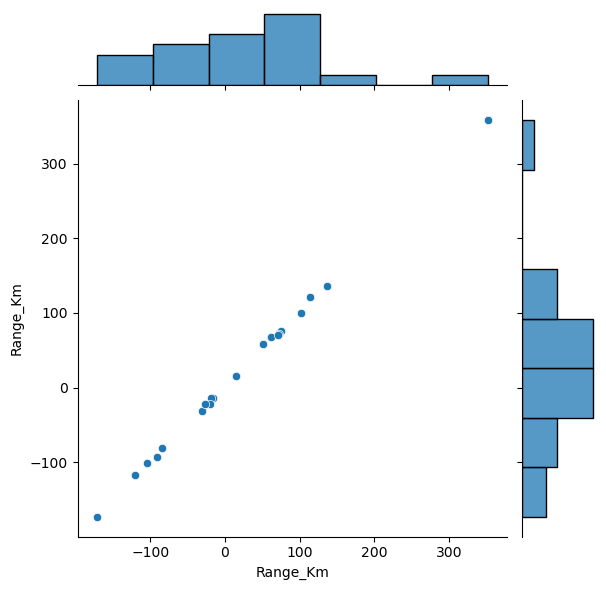

In [72]:
# Jointplot

sns.jointplot(data=ev, x=residual_lasso, y=residual_ridge, kind = 'scatter')


# Conclusions

From my analysis, affect EV Range Factors are TopSpeed_KmH, Efficiency_WhKm, AccelSec, Segment, Seats and PriceEuro.

There are a number of factors that also affect EV range:
    
- Your driving style

- Terrain and road condition

- The weather

- The weight of the vehicle

- Using the heating and air conditioning

- Condition of the tyres

- Condition of the battery


Tips to Maximize Range (Example for EV car - Tesla Model Y)

- Slow down your driving and avoid frequent and rapid acceleration.

- If safe to do so, modulate the accelerator pedal instead of using the brake pedal when gradually slowing down.

- Limit the use of resources such as heating and air conditioning. 

-  With your vehicle plugged in, use the mobile app to precondition your vehicle to ensure the cabin is at a comfortable temperature and windows are defrosted (if needed) before your drive 

- Touch Schedule, available on both the charging and climate control screens, to set a time when you want your vehicle to be ready to drive

- Set Stopping Mode to Hold to gain the benefit of regenerative braking at low driving speeds

- Ensure the wheels are aligned to specification, the tires are kept at the recommended inflation pressures (see Tire Care and Maintenance), and are rotated when needed

- Install aero covers (if equipped) to reduce wind resistance 

- Lighten your load by removing any unnecessary cargo.

- Fully raise all windows.

- Features such as Sentry Mode and Cabin Overheat Protection can impact range. Disable features when not needed.

- To prevent an excessive amount of energy consumption while the vehicle is idle, keep the vehicle plugged in when not in use.

- Minimize the use of DC chargers (such as Superchargers) for optimal Battery health.

Reference from: 

https://www.tesla.com/ownersmanual/modely/en_kr/GUID-4AC32116-979A-4146-A935-F41F8551AFE6.html

https://iq.opengenus.org/advantages-and-disadvantages-of-linear-regression/

https://www.statology.org/linear-regression-assumptions/

Datasets Reference :  

https://www.kaggle.com/datasets/geoffnel/evs-one-electric-vehicle-dataset

In [73]:
from ibm_watson_machine_learning import APIClient

wml_credentials = {
    "url": "https://us-south.ml.cloud.ibm.com",
    "apikey": "uhhh-nopp-use-yours"
}

client = APIClient(wml_credentials)

def guid_from_space_name(client, space_name):
    space = client.spaces.get_details()
    # Print available space names for debugging
    print("Available spaces:")
    for item in space['resources']:
        print(item['entity']["name"])
    
    for item in space['resources']:
        if item['entity']["name"] == space_name:
            return item['metadata']['id']
    raise ValueError(f"Space with name '{space_name}' not found.")

space_uid = guid_from_space_name(client, 'models')
print("Space UID = " + space_uid)


Available spaces:
models
Space UID = c8c24d54-c075-4681-9b0e-ecac3e4989bc


In [74]:
client.set.default_space(space_uid)

'SUCCESS'

In [75]:
client.software_specifications.list()

----------------------------  ------------------------------------  ----  ------------  --------------------------
NAME                          ID                                    TYPE  STATE         REPLACEMENT
default_py3.6                 0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base  retired       runtime-23.1-py3.10
autoai-ts_rt23.1-py3.10       01ce9391-1a79-5a33-94fb-2e134337f314  base  supported     autoai-ts_rt24.1-py3.11
kernel-spark3.2-scala2.12     020d69ce-7ac1-5e68-ac1a-31189867356a  base  retired
pytorch-onnx_1.3-py3.7-edt    069ea134-3346-5748-b513-49120e15d288  base  retired
tensorflow_rt23.1-py3.10      079a91e0-245f-5269-8926-3c20b28f37dc  base  supported     tensorflow_rt24.1-py3.11
scikit-learn_0.20-py3.6       09c5a1d0-9c1e-4473-a344-eb7b665ff687  base  retired       runtime-23.1-py3.10
spark-mllib_3.0-scala_2.12    09f4cff0-90a7-5899-b9ed-1ef348aebdee  base  retired
pytorch-onnx_rt22.1-py3.9     0b848dd4-e681-5599-be41-b5f6fccc6471  base  retired       pytorch-on

,NAME,ID,TYPE,STATE,REPLACEMENT
0,default_py3.6,0062b8c9-8b7d-44a0-a9b9-46c416adcbd9,base,retired,runtime-23.1-py3.10
1,autoai-ts_rt23.1-py3.10,01ce9391-1a79-5a33-94fb-2e134337f314,base,supported,autoai-ts_rt24.1-py3.11
2,kernel-spark3.2-scala2.12,020d69ce-7ac1-5e68-ac1a-31189867356a,base,retired,
3,pytorch-onnx_1.3-py3.7-edt,069ea134-3346-5748-b513-49120e15d288,base,retired,
4,tensorflow_rt23.1-py3.10,079a91e0-245f-5269-8926-3c20b28f37dc,base,supported,tensorflow_rt24.1-py3.11
5,scikit-learn_0.20-py3.6,09c5a1d0-9c1e-4473-a344-eb7b665ff687,base,retired,runtime-23.1-py3.10
6,spark-mllib_3.0-scala_2.12,09f4cff0-90a7-5899-b9ed-1ef348aebdee,base,retired,
7,pytorch-onnx_rt22.1-py3.9,0b848dd4-e681-5599-be41-b5f6fccc6471,base,retired,pytorch-onnx_rt23.1-py3.10
8,ai-function_0.1-py3.6,0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda,base,retired,runtime-23.1-py3.10
9,watsonx-cfm-caikit-1.0,0cee3c55-472f-57b1-84bd-72f5d066dbe4,base,not_provided,


In [76]:
software_spec_uid = client.software_specifications.get_uid_by_name("runtime-23.1-py3.10")
software_spec_uid

'336b29df-e0e1-5e7d-b6a5-f6ab722625b2'

In [81]:
model_details = client.repository.store_model(
    model=lr,
    meta_props={
        client.repository.ModelMetaNames.NAME: "ev_modeling",
        client.repository.ModelMetaNames.TYPE: "scikit-learn_1.1",
        client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid
    }
)

model_id = client.repository.get_model_id(model_details)
print("Model ID:", model_id)


Model ID: c696cf60-62a4-4fb7-90a6-fe7cdabfd9b8


In [78]:
import pickle

# Assuming lr is your scikit-learn model
model_bytes = pickle.dumps(lr)
